In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
warnings.filterwarnings("ignore")
rqdatac.init()

Cannot initialize filter sz3: File not found


In [3]:
df_etf = pd.read_excel('etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]

In [4]:
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [5]:
df_etf.head()

,order_book_id,market_tplus,symbol,exchange,status,establishment_date,de_listed_date,type,trading_hours,abbrev_symbol,round_lot,listed_date,underlying_order_book_id,underlying_name,least_redeem,trading_code,board_type
14,159507.XSHE,1,广发国证通信ETF,XSHE,Active,2023-06-08,0000-00-00,ETF,"09:31-11:30,13:01-15:00",GFGZTXETF,100,2023-06-21,399389.XSHE,国证通信指数,1000000.0,159507,1
93,159611.XSHE,1,广发中证全指电力ETF,XSHE,Active,2021-12-29,0000-00-00,ETF,"09:31-11:30,13:01-15:00",GFZZQZDLETF,100,2022-01-07,H30199.XSHG,中证全指电力公用事业指数,800000.0,159611,1
100,159619.XSHE,1,国泰中证基建ETF,XSHE,Active,2022-02-09,0000-00-00,ETF,"09:31-11:30,13:01-15:00",GTZZJJETF,100,2022-02-18,930608.INDX,中证基建指数,1000000.0,159619,1
218,159766.XSHE,1,富国中证旅游主题ETF,XSHE,Active,2021-07-15,0000-00-00,ETF,"09:31-11:30,13:01-15:00",FGZZLYZTETF,100,2021-07-23,930633.INDX,中证旅游主题指数,500000.0,159766,1
268,159825.XSHE,1,富国中证农业主题ETF,XSHE,Active,2020-12-10,0000-00-00,ETF,"09:31-11:30,13:01-15:00",FGZZNYZTETF,100,2020-12-29,000949.XSHG,中证农业主题指数,1000000.0,159825,1


In [6]:
etf_code2 = df_etf.order_book_id.values.tolist()
df_price = get_price(etf_code2, start_date='20160101' ,end_date='20231231' , fields=['open','high','low','close'])
df_price

open   high    low  close
order_book_id date                                  
159507.XSHE   2023-06-21  1.058  1.060  1.010  1.024
              2023-06-26  1.009  1.020  0.989  0.993
              2023-06-27  0.993  1.014  0.990  1.010
              2023-06-28  1.008  1.008  0.963  0.983
              2023-06-29  0.980  1.004  0.980  1.001
...                         ...    ...    ...    ...
561320.XSHG   2023-12-25  0.824  0.829  0.822  0.829
              2023-12-26  0.832  0.832  0.821  0.821
              2023-12-27  0.821  0.823  0.815  0.818
              2023-12-28  0.818  0.832  0.817  0.829
              2023-12-29  0.829  0.829  0.825  0.828

[28416 rows x 4 columns]

In [7]:
df_price = df_price.dropna().reset_index()
df_price = df_price.sort_index().fillna(method='ffill').dropna()
df_price['date'] = df_price['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# 按收盘价计算每日涨幅
df_price['pct'] = df_price['close'] / df_price['close'].shift(1) - 1.0
df_price = df_price.dropna().reset_index(drop=True)
df_price

,order_book_id,date,open,high,low,close,pct
0,159507.XSHE,2023-06-26,1.009,1.020,0.989,0.993,-0.030273
1,159507.XSHE,2023-06-27,0.993,1.014,0.990,1.010,0.017120
2,159507.XSHE,2023-06-28,1.008,1.008,0.963,0.983,-0.026733
3,159507.XSHE,2023-06-29,0.980,1.004,0.980,1.001,0.018311
4,159507.XSHE,2023-06-30,1.002,1.023,0.995,1.014,0.012987
...,...,...,...,...,...,...,...
28410,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205
28411,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650
28412,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654
28413,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447


In [8]:
import talib
import pandas as pd

# 定义一个函数用于计算移动平均线
def calculate_sma(group):
    close_prices = group['close'].values
    group['sma5'] = talib.SMA(close_prices, timeperiod=5)
    group['sma10'] = talib.SMA(close_prices, timeperiod=10)
    group['sma20'] = talib.SMA(close_prices, timeperiod=20)
    group['sma30'] = talib.SMA(close_prices, timeperiod=30)
    group['sma40'] = talib.SMA(close_prices, timeperiod=40)
    group['sma50'] = talib.SMA(close_prices, timeperiod=50)
    group['sma60'] = talib.SMA(close_prices, timeperiod=60)
    group['sma75'] = talib.SMA(close_prices, timeperiod=75)
    return group
# 最近十天累计收益率
def calculate_roc(group):
    group['roc'] = group.close.pct_change(periods = 10)
    return group
# 最近十天收盘价累计增长量
def calculate_mom(group):
    group['mom'] = group.close.diff(periods = 10)
    return group
# label
def calculate_label(group):
    group['label'] = 0
    group['avg_returns'] = group['pct'].rolling(window=5).mean()
    group.loc[(group['avg_returns'] > 0.003) & (group['pct'] > 0), 'label'] = 1
    return group

df_price = df_price.groupby('order_book_id').apply(calculate_sma).dropna().reset_index(drop=True)
df_price = df_price.groupby('order_book_id').apply(calculate_roc).dropna().reset_index(drop=True)
df_price = df_price.groupby('order_book_id').apply(calculate_mom).dropna().reset_index(drop=True)
df_price = df_price.groupby('order_book_id').apply(calculate_label).dropna().reset_index(drop=True)
df_price

,order_book_id,date,open,high,low,close,pct,sma5,sma10,sma20,sma30,sma40,sma50,sma60,sma75,roc,mom,label,avg_returns
0,159507.XSHE,2023-11-17,0.874,0.893,0.874,0.892,0.009050,0.8924,0.8840,0.86715,0.883000,0.887225,0.89266,0.894233,0.904747,0.048179,0.041,1,0.003917
1,159507.XSHE,2023-11-20,0.892,0.895,0.884,0.890,-0.002242,0.8922,0.8864,0.86890,0.881900,0.886925,0.89232,0.894167,0.903907,0.027714,0.024,0,-0.000189
2,159507.XSHE,2023-11-21,0.889,0.896,0.881,0.884,-0.006742,0.8892,0.8869,0.87060,0.880600,0.886800,0.89156,0.893950,0.903013,0.005688,0.005,0,-0.003333
3,159507.XSHE,2023-11-22,0.880,0.882,0.870,0.871,-0.014706,0.8842,0.8861,0.87210,0.878533,0.886450,0.89066,0.893000,0.901813,-0.009101,-0.008,0,-0.005607
4,159507.XSHE,2023-11-23,0.868,0.878,0.862,0.878,0.008037,0.8830,0.8860,0.87285,0.876733,0.886375,0.88992,0.892567,0.900720,-0.001138,-0.001,0,-0.001321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25862,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205,0.8296,0.8361,0.84490,0.848300,0.848725,0.84694,0.850833,0.858760,-0.029274,-0.025,0,-0.001901
25863,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650,0.8266,0.8326,0.84300,0.847400,0.847850,0.84624,0.849767,0.857600,-0.040888,-0.035,0,-0.003592
25864,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654,0.8252,0.8301,0.84110,0.846200,0.847000,0.84566,0.848717,0.856440,-0.029656,-0.025,0,-0.001691
25865,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447,0.8254,0.8288,0.83950,0.845533,0.846525,0.84560,0.847867,0.855587,-0.015439,-0.013,0,0.000271


In [9]:
train_start = pd.to_datetime('2016-01-01')
train_end = pd.to_datetime('2019-12-31')
test_start = pd.to_datetime('2020-01-01')
test_end = pd.to_datetime('2023-12-31')
# 按照股票代码进行分组，并划分训练集和测试集
train_data = pd.DataFrame()
test_data = pd.DataFrame()
df_price['date'] = pd.to_datetime(df_price['date'])

for order_book_id, group in df_price.groupby('order_book_id'):
    train_group = group[(group['date'] >= train_start) & (group['date'] <= train_end)]
    test_group = group[(group['date'] >= test_start) & (group['date'] <= test_end)]
    train_data = pd.concat([train_data, train_group])
    test_data = pd.concat([test_data, test_group])

train_data

,order_book_id,date,open,high,low,close,pct,sma5,sma10,sma20,sma30,sma40,sma50,sma60,sma75,roc,mom,label,avg_returns
3684,159928.XSHE,2016-05-30,0.3215,0.3260,0.3210,0.3252,-0.002454,0.32592,0.32745,0.329480,0.325280,0.324735,0.323552,0.320440,0.316156,-0.021072,-0.0070,0,-0.002610
3685,159928.XSHE,2016-05-31,0.3298,0.3300,0.3260,0.3298,0.014145,0.32632,0.32715,0.329380,0.325607,0.324898,0.323912,0.320895,0.316567,-0.009014,-0.0030,0,0.001251
3686,159928.XSHE,2016-06-01,0.3285,0.3308,0.3250,0.3308,0.003032,0.32712,0.32765,0.329345,0.325973,0.325048,0.324204,0.321292,0.317051,0.015347,0.0050,0,0.002468
3687,159928.XSHE,2016-06-02,0.3290,0.3350,0.3290,0.3325,0.005139,0.32886,0.32817,0.329295,0.326647,0.325198,0.324550,0.321792,0.317487,0.015888,0.0052,1,0.005331
3688,159928.XSHE,2016-06-03,0.3325,0.3402,0.3325,0.3390,0.019549,0.33146,0.32912,0.329870,0.327537,0.325603,0.324980,0.322397,0.317983,0.028832,0.0095,1,0.007882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21760,513050.XSHG,2019-12-25,1.4380,1.4380,1.4240,1.4270,-0.009028,1.41780,1.39690,1.360550,1.335033,1.319775,1.302100,1.287033,1.280213,0.070518,0.0940,0,0.005154
21761,513050.XSHG,2019-12-26,1.4270,1.4490,1.4260,1.4470,0.014015,1.42800,1.40630,1.366200,1.340967,1.324825,1.306220,1.290833,1.282773,0.069475,0.0940,1,0.007239
21762,513050.XSHG,2019-12-27,1.4530,1.4760,1.4530,1.4740,0.018659,1.44160,1.41650,1.373950,1.347700,1.330450,1.310960,1.294950,1.285760,0.074344,0.1020,1,0.009538
21763,513050.XSHG,2019-12-30,1.4520,1.4520,1.4370,1.4450,-0.019674,1.44660,1.42350,1.380100,1.352900,1.335150,1.315360,1.298883,1.288333,0.050909,0.0700,0,0.003611


In [10]:
test_data

,order_book_id,date,open,high,low,close,pct,sma5,sma10,sma20,sma30,sma40,sma50,sma60,sma75,roc,mom,label,avg_returns
0,159507.XSHE,2023-11-17,0.874,0.893,0.874,0.892,0.009050,0.8924,0.8840,0.86715,0.883000,0.887225,0.89266,0.894233,0.904747,0.048179,0.041,1,0.003917
1,159507.XSHE,2023-11-20,0.892,0.895,0.884,0.890,-0.002242,0.8922,0.8864,0.86890,0.881900,0.886925,0.89232,0.894167,0.903907,0.027714,0.024,0,-0.000189
2,159507.XSHE,2023-11-21,0.889,0.896,0.881,0.884,-0.006742,0.8892,0.8869,0.87060,0.880600,0.886800,0.89156,0.893950,0.903013,0.005688,0.005,0,-0.003333
3,159507.XSHE,2023-11-22,0.880,0.882,0.870,0.871,-0.014706,0.8842,0.8861,0.87210,0.878533,0.886450,0.89066,0.893000,0.901813,-0.009101,-0.008,0,-0.005607
4,159507.XSHE,2023-11-23,0.868,0.878,0.862,0.878,0.008037,0.8830,0.8860,0.87285,0.876733,0.886375,0.88992,0.892567,0.900720,-0.001138,-0.001,0,-0.001321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25862,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205,0.8296,0.8361,0.84490,0.848300,0.848725,0.84694,0.850833,0.858760,-0.029274,-0.025,0,-0.001901
25863,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650,0.8266,0.8326,0.84300,0.847400,0.847850,0.84624,0.849767,0.857600,-0.040888,-0.035,0,-0.003592
25864,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654,0.8252,0.8301,0.84110,0.846200,0.847000,0.84566,0.848717,0.856440,-0.029656,-0.025,0,-0.001691
25865,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447,0.8254,0.8288,0.83950,0.845533,0.846525,0.84560,0.847867,0.855587,-0.015439,-0.013,0,0.000271


In [11]:
X_train = train_data[['open','high','low','close','sma5','sma10', 'sma20', 'sma30', 'sma40', 'sma50', 'sma60', 'sma75', 'roc', 'mom']]
y_train = train_data.label.values
X_test = test_data[['open','high','low','close','sma5','sma10', 'sma20', 'sma30', 'sma40', 'sma50', 'sma60', 'sma75', 'roc', 'mom']]
y_test = test_data.label.values

In [12]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()  # 根据实际选择的模型修改
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_  # 获取最佳模型

# 6. 模型评估
y_test_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

confusion_mat = confusion_matrix(y_test, y_test_pred)

# 7. 输出测试集 ETF 上涨概率作为 PMI 的替代性变量
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # 获取正类的预测概率

# 使用 y_test_prob 进行后续的决策或分析
y_test_prob

array([0.369405  , 0.27880794, 0.13100263, ..., 0.05854116, 0.07313204,
       0.07589384])

In [14]:
test_data['label_prob'] = y_test_prob
test_data.to_csv('test.csv')

,order_book_id,date,open,high,low,close,pct,sma5,sma10,sma20,sma30,sma40,sma50,sma60,sma75,roc,mom,label,avg_returns,label_prob
0,159507.XSHE,2023-11-17,0.874,0.893,0.874,0.892,0.009050,0.8924,0.8840,0.86715,0.883000,0.887225,0.89266,0.894233,0.904747,0.048179,0.041,1,0.003917,0.369405
1,159507.XSHE,2023-11-20,0.892,0.895,0.884,0.890,-0.002242,0.8922,0.8864,0.86890,0.881900,0.886925,0.89232,0.894167,0.903907,0.027714,0.024,0,-0.000189,0.278808
2,159507.XSHE,2023-11-21,0.889,0.896,0.881,0.884,-0.006742,0.8892,0.8869,0.87060,0.880600,0.886800,0.89156,0.893950,0.903013,0.005688,0.005,0,-0.003333,0.131003
3,159507.XSHE,2023-11-22,0.880,0.882,0.870,0.871,-0.014706,0.8842,0.8861,0.87210,0.878533,0.886450,0.89066,0.893000,0.901813,-0.009101,-0.008,0,-0.005607,0.081953
4,159507.XSHE,2023-11-23,0.868,0.878,0.862,0.878,0.008037,0.8830,0.8860,0.87285,0.876733,0.886375,0.88992,0.892567,0.900720,-0.001138,-0.001,0,-0.001321,0.095258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25862,561320.XSHG,2023-12-25,0.824,0.829,0.822,0.829,-0.001205,0.8296,0.8361,0.84490,0.848300,0.848725,0.84694,0.850833,0.858760,-0.029274,-0.025,0,-0.001901,0.058551
25863,561320.XSHG,2023-12-26,0.832,0.832,0.821,0.821,-0.009650,0.8266,0.8326,0.84300,0.847400,0.847850,0.84624,0.849767,0.857600,-0.040888,-0.035,0,-0.003592,0.044325
25864,561320.XSHG,2023-12-27,0.821,0.823,0.815,0.818,-0.003654,0.8252,0.8301,0.84110,0.846200,0.847000,0.84566,0.848717,0.856440,-0.029656,-0.025,0,-0.001691,0.058541
25865,561320.XSHG,2023-12-28,0.818,0.832,0.817,0.829,0.013447,0.8254,0.8288,0.83950,0.845533,0.846525,0.84560,0.847867,0.855587,-0.015439,-0.013,0,0.000271,0.073132


In [15]:
test_data.to_csv('test.csv')

In [39]:
from sklearn.linear_model import LinearRegression
def calculate_beta(df, window=18):
    if df.shape[0] < window:
        return np.nan
    x = df['low'].values
    y = df['high'].values
    beta = LinearRegression().fit(x.reshape(-1, 1), y).coef_[0]
    return beta

N = 18 #计算斜率时的数据点个数
df_price['beta'] = [calculate_beta(df,window=N) for df in df_price.rolling(N)]

df_price.tail(20)

,order_book_id,date,open,high,low,close,pct,beta
109,159507.XSHE,2023-12-04,0.873,0.881,0.872,0.877,0.000000,1.051841
110,159507.XSHE,2023-12-05,0.871,0.871,0.853,0.853,-0.027366,1.025980
111,159507.XSHE,2023-12-06,0.848,0.860,0.844,0.848,-0.005862,1.017306
112,159507.XSHE,2023-12-07,0.852,0.857,0.847,0.854,0.007075,1.025463
113,159507.XSHE,2023-12-08,0.859,0.887,0.858,0.882,0.032787,0.980576
114,159507.XSHE,2023-12-11,0.880,0.891,0.870,0.890,0.009070,0.980952
115,159507.XSHE,2023-12-12,0.890,0.892,0.878,0.885,-0.005618,0.997666
116,159507.XSHE,2023-12-13,0.883,0.884,0.873,0.874,-0.012429,0.961173
117,159507.XSHE,2023-12-14,0.870,0.886,0.869,0.869,-0.005721,1.000722
118,159507.XSHE,2023-12-15,0.869,0.872,0.859,0.861,-0.009206,0.999833


均值：0.905
标准差：0.132
偏度：-0.992
峰度：0.608


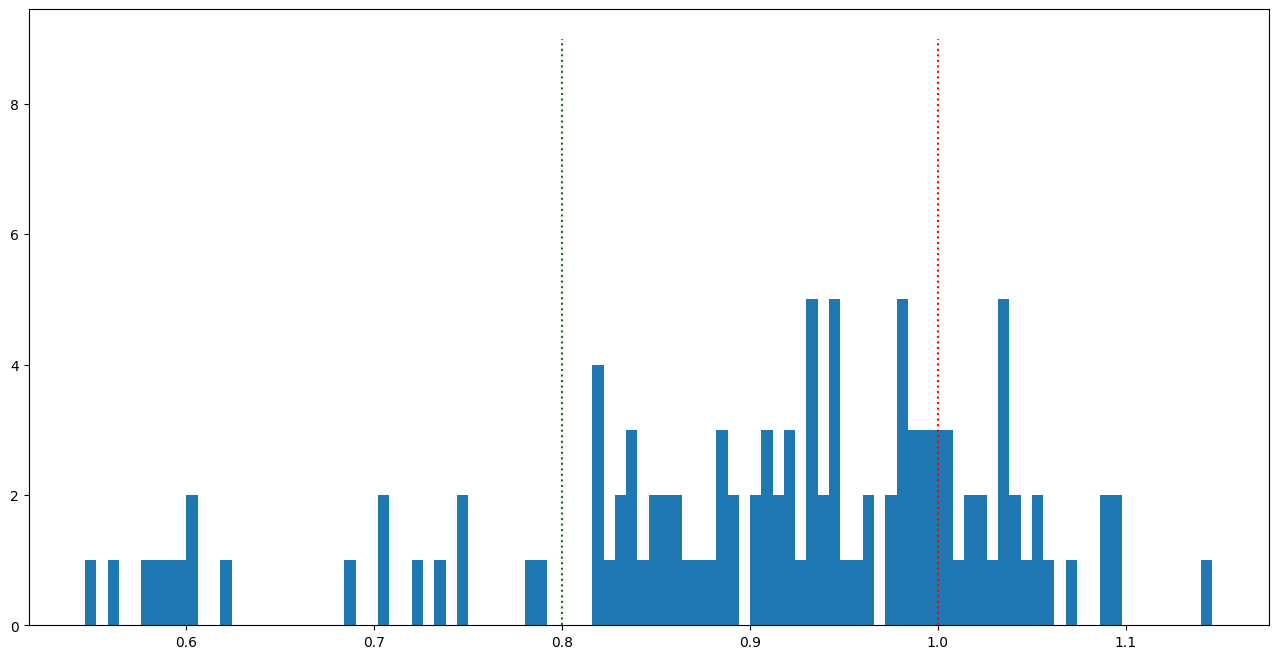

In [40]:
# RSRS值大于1.0的时候，买入持有；RSRS值小于0.8，卖出平仓

print('均值：%.3f' %df_price['beta'].mean())
print('标准差：%.3f' %df_price['beta'].std())
print('偏度：%.3f' %df_price['beta'].skew())
print('峰度：%.3f' %df_price['beta'].kurt())

y = list(range(10))
plt.figure(figsize=(16,8))
plt.hist(df_price['beta'], bins=100)
plt.plot(len(y)*[0.8], y, color='green', linestyle=':')
plt.plot(len(y)*[1.0], y, color='red', linestyle=':')
plt.show()


RSRS斜率量化择时策略的年化收益率：-6.46%


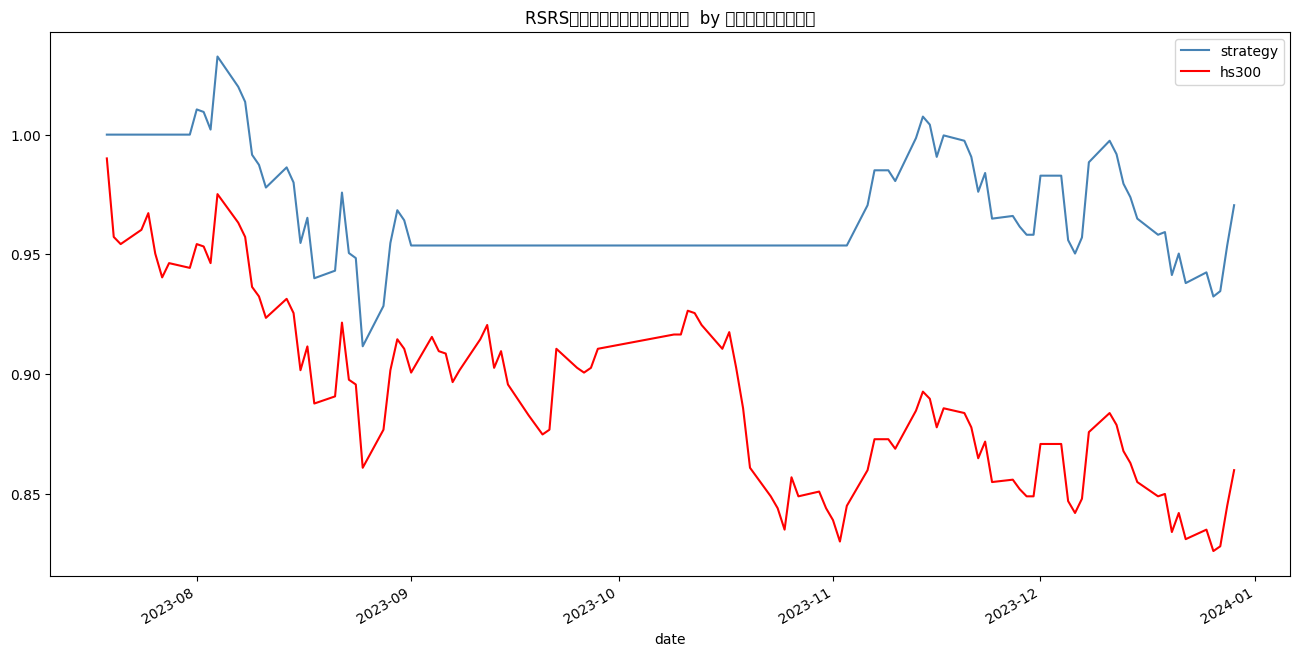

In [41]:
buy_thre = 1.0  # 买入阈值
sell_thre = 0.8 # 卖出阈值
data1 = df_price.dropna().copy().reset_index(drop=True)

data1['flag'] = 0 # 买卖标记，买入：1，卖出：-1
data1['position'] = 0 # 持仓状态，持仓：1，不持仓：0
position = 0 
for i in range(1, data1.shape[0]-1):
    beta = data1.loc[i,'beta']
    if (position == 0) and (beta > buy_thre):
        # 若之前无持仓，上穿买入阈值则买入
        data1.loc[i,'flag'] = 1
        data1.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (beta < sell_thre): 
        # 若之前有持仓，下穿卖出阈值则卖出
        data1.loc[i,'flag'] = -1
        data1.loc[i+1,'position'] = 0     
        position = 0
    else:
        # 不触发阈值，则保持原有持仓状态
        data1.loc[i+1,'position'] = data1.loc[i,'position']     

data1['strategy_pct'] = data1['pct'] * data1['position']
data1['strategy'] = (1.0 + data1['strategy_pct']).cumprod()
data1['hs300'] = (1.0 + data1['pct']).cumprod()

# 粗略计算年化收益率
annual_return = 100 * (pow(data1['strategy'].iloc[-1], 250/data1.shape[0]) - 1.0)
print('RSRS斜率量化择时策略的年化收益率：%.2f%%' %annual_return)

#将索引从字符串转换为日期格式，方便展示
data1.index = pd.to_datetime(data1['date'])
ax = data1[['strategy','hs300']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS斜率量化指数择时策略净值  by 公众号【量化君也】')
plt.show()

In [53]:
convertible.instruments("128054.XSHE")

Instrument(
order_book_id='128054.XSHE',
symbol='中宠转债',
full_name='烟台中宠食品股份有限公司公开发行可转换公司债券',
exchange='XSHE',
bond_type='cb',
trade_type='dirty_price',
value_date=datetime.datetime(2019, 2, 15, 0, 0),
listed_date=datetime.datetime(2019, 3, 14, 0, 0),
maturity_date=datetime.datetime(2025, 2, 15, 0, 0),
early_maturity_date=datetime.datetime(2020, 7, 15, 0, 0),
par_value=100.0,
coupon_rate=0.004,
coupon_frequency=1,
coupon_method='stepup_rate',
compensation_rate=0.075,
total_issue_size=194240000.0,
de_listed_date=datetime.datetime(2020, 7, 23, 0, 0),
stock_code='002891.XSHE',
conversion_start_date=datetime.datetime(2019, 8, 22, 0, 0),
conversion_end_date=datetime.datetime(2025, 2, 14, 0, 0),
redemption_price=110.0,
stop_trading_date=datetime.datetime(2020, 7, 1, 0, 0),
issue_price=100.0,
call_protection=6.0
)

In [63]:
logger.info(history_bars('000002.XSHE', 5, '1d', 'close'))

RuntimeError: stack is empty